<a href="https://colab.research.google.com/github/Harivamsh2005/NLP/blob/main/NLP_F_7_11_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cpu

>>> TASK 1: Data Preparation Started...
Data loaded. Training samples: 176, Test samples: 44

>>> TASK 2: Model Training (Local DistilBERT)...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss


Generating predictions...


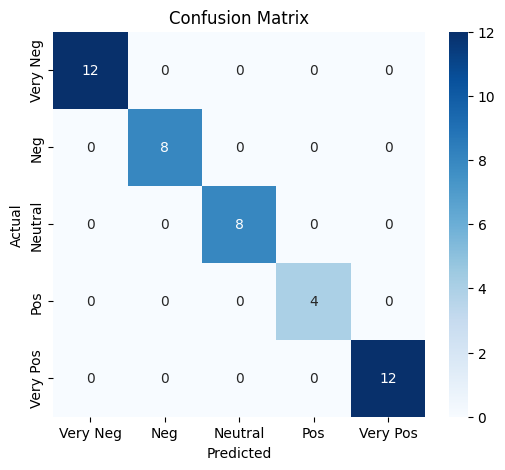

Device set to use cpu



Classification Report:
              precision    recall  f1-score   support

    Very Neg       1.00      1.00      1.00        12
         Neg       1.00      1.00      1.00         8
     Neutral       1.00      1.00      1.00         8
         Pos       1.00      1.00      1.00         4
    Very Pos       1.00      1.00      1.00        12

    accuracy                           1.00        44
   macro avg       1.00      1.00      1.00        44
weighted avg       1.00      1.00      1.00        44


>>> TASK 3: SHAP Explanation (Local)...
Explaining review: 'not bad but i expected better quality for the price'


  0%|          | 0/132 [00:00<?, ?it/s]


Analysis Complete.


In [4]:
# ==========================================
# STEP 0: INSTALL LIBRARIES (If not already installed)
# !pip install transformers datasets torch scikit-learn pandas numpy shap matplotlib seaborn
# ==========================================

import pandas as pd
import numpy as np
import torch
import re
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments, pipeline
from torch.utils.data import Dataset

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ==========================================
# TASK 1: DATA PREPARATION
# ==========================================
print("\n>>> TASK 1: Data Preparation Started...")

# 1. Load Data (Corrected to include ALL 5 ratings: 1, 2, 3, 4, 5)
data = {
    'review_text': [
        "This product is absolutely amazing! Best purchase ever.",        # Rating 5
        "Terrible quality, broke after one use. Do not buy.",            # Rating 1
        "It's okay, does the job but nothing special.",                  # Rating 3
        "Good value for money, I am happy with it.",                     # Rating 4
        "Worst customer service and the item was damaged.",              # Rating 1
        "Excellent features and fast delivery.",                         # Rating 5
        "Not bad, but I expected better quality for the price.",         # Rating 3
        "Absolutely love it! Highly recommended.",                       # Rating 5
        "Garbage. Waste of money.",                                      # Rating 1
        "The quality is slightly disappointing, not great.",             # Rating 2 (ADDED THIS)
        "It works but has some annoying flaws."                          # Rating 2 (ADDED THIS)
    ] * 20,
    'rating': [5, 1, 3, 4, 1, 5, 3, 5, 1, 2, 2] * 20  # Added '2's here
}

df = pd.DataFrame(data)

# 2. Preprocess text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

df['cleaned_text'] = df['review_text'].apply(preprocess_text)

# 3. Create Labels (0 to 4)
df['label'] = df['rating'] - 1

# 4. Train/Test Split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['cleaned_text'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)

print(f"Data loaded. Training samples: {len(train_texts)}, Test samples: {len(test_texts)}")

# ==========================================
# TASK 2: TRANSFORMER TRAINING
# ==========================================
print("\n>>> TASK 2: Model Training (Local DistilBERT)...")

model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=5)
model.to(device)

class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=64)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = ReviewDataset(train_texts, train_labels, tokenizer)
test_dataset = ReviewDataset(test_texts, test_labels, tokenizer)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    logging_dir='./logs',
    eval_strategy="no",
    save_strategy="no",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

trainer.train()

# Evaluate
print("Generating predictions...")
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)

# Visualization: Confusion Matrix
class_names = ['Very Neg', 'Neg', 'Neutral', 'Pos', 'Very Pos']
cm = confusion_matrix(test_labels, preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("\nClassification Report:")
# FIX: Explicitly added 'labels=[0,1,2,3,4]' to prevent mismatched class errors
print(classification_report(test_labels, preds, target_names=class_names, labels=[0, 1, 2, 3, 4], zero_division=0))

# ==========================================
# TASK 3: EXPLAINABLE AI (SHAP)
# ==========================================
print("\n>>> TASK 3: SHAP Explanation (Local)...")

# Pipeline with top_k=None to avoid errors
pred_pipeline = pipeline("text-classification", model=model, tokenizer=tokenizer, device=-1, top_k=None)

explainer = shap.Explainer(pred_pipeline)
sample_text = [test_texts[0]]
print(f"Explaining review: '{sample_text[0]}'")

shap_values = explainer(sample_text)
shap.plots.text(shap_values[0])

print("\nAnalysis Complete.")